In [1]:
from jax_md import *
import jax
import jax.random as jr
import jax.numpy as jnp
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)

In [2]:
dim = 2
N = 256
box_size = quantity.box_size_at_number_density(N, 1, dim)

In [3]:
displacement, shift = space.periodic(box_size)
metric = space.metric(displacement)
v_displacement = space.map_product(displacement)
v_metric = space.map_product(metric)

My way of doing a brownian simulation, and saving the state at every timestep

In [4]:
def brownian_simulation(key, temperature, dt, steps, energy_fn):
    pos_key, sim_key, times_key = jr.split(key, 3)
    # R = jr.uniform(pos_key, (N, 2), maxval=box_size)
    R = jr.uniform(pos_key, (N, 2), minval=0.45*box_size, maxval=0.55*box_size)

    init_fn, apply_fn = simulate.brownian(energy_fn, shift, dt, temperature)
    initial_state = init_fn(sim_key, R)
    state = init_fn(sim_key, R)

    do_step = lambda state, t: (apply_fn(state), apply_fn(state))
    final_state, intermediate_states = jax.lax.scan(do_step, state, steps)

    return initial_state.position, final_state.position, intermediate_states.position, times_key

In [5]:
initial, final, intermediate, times_key = brownian_simulation(jr.PRNGKey(0), 0, 0.01, jnp.arange(1000), lambda r: 0.)

In [6]:
final = jnp.expand_dims(final, 0)
initial = jnp.expand_dims(initial, 0)
all_states = jnp.concatenate((initial, intermediate, final), axis=0)
print(jnp.shape(all_states))

(1002, 256, 2)


In [7]:
jnp.save("bm", all_states)

In [259]:
rr = jnp.linspace(0, box_size, 100)
dr = box_size/100
g = quantity.pair_correlation(space.metric(displacement), rr, dr/6, compute_average=True)

In [260]:
M = 25
times = jr.randint(times_key, (M,), minval=0, maxval=1000)
# print(times)
rdfs = []
for t in times:
    rdfs.append(g(all_states[t, :, :]))
#print(rdf)

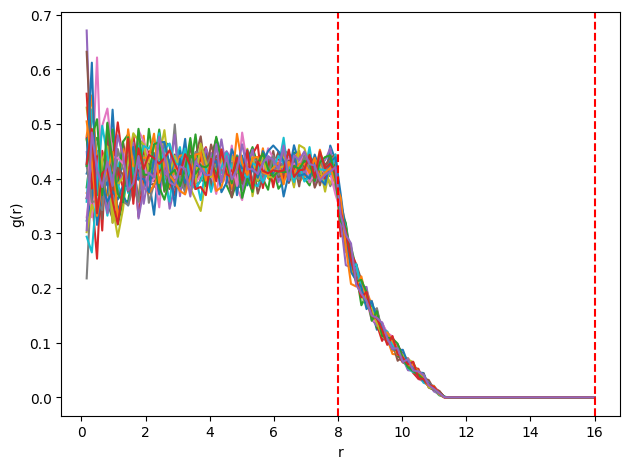

In [261]:
for k in range(M):
    plt.plot(rr[1:], rdfs[k][1:])
plt.axvline(box_size/2, linestyle="--", color="red")
plt.axvline(box_size, linestyle="--", color="red")
plt.xlabel("r")
plt.ylabel("g(r)")
plt.tight_layout()
plt.show()

The JAX-MD way of doing a brownian simulation, and saving the state at every timestep

In [196]:
def run_brownian(
    energy_fn,
    R_init,
    shift,
    key,
    num_total_steps,
    record_every,
    dt,
    measure_fn=lambda R: R
  ):

    init, apply = simulate.brownian(energy_fn, shift, dt, kT=0.05)
    apply = jax.jit(apply)

    @jax.jit
    def apply_single_step(state, t):
        return apply(state), 0

    @jax.jit
    def apply_many_steps(state, t_list):
        state, _ = jax.lax.scan(apply_single_step, state, t_list)
        return state, measure_fn(state.position)

    # initialize the system
    key, split = jr.split(key)
    initial_state = init(split, R_init)

    # run the simulation
    final_state, data = jax.lax.scan(
        apply_many_steps,
        initial_state,
        jnp.arange(num_total_steps).reshape(
            num_total_steps // record_every, record_every
        ),
    )

    # return the trajectory
    return data

In [197]:
trajecs = run_brownian(energy.lennard_jones_pair(displacement), jr.uniform(jr.PRNGKey(0), (N, 2), maxval=box_size), shift, jr.PRNGKey(0), 1000, 1, 0.01)

In [198]:
print(jnp.shape(trajecs))
jnp.save("trajecs", trajecs)

(1000, 512, 2)


In [199]:
rr = jnp.linspace(0, box_size, 100)
dr = box_size/100
g = quantity.pair_correlation(space.metric(displacement), rr, dr/6, compute_average=True)

In [200]:
rdf = g(all_states[-1, :, :])
# print(rdf)

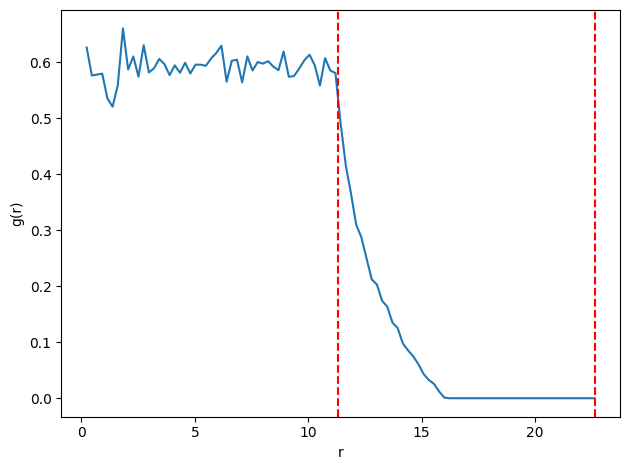

In [201]:
plt.plot(rr[1:], rdf[1:])
plt.axvline(box_size/2, linestyle="--", color="red")
plt.axvline(box_size, linestyle="--", color="red")
plt.xlabel("r")
plt.ylabel("g(r)")
plt.tight_layout()
plt.show()